In [1]:
from robot_vlp.config import INTERIM_DATA_DIR, PROCESSED_DATA_DIR, FIGURES_DIR, MODELS_DIR, EXPERIMENT_DATA_DIR
import pickle
import numpy as np
import keras
import robot_vlp.data.preprocessing as p
import matplotlib.pyplot as plt
import robot_vlp.data_collection.communication as c
import pandas as pd
from kerastuner import HyperParameters
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization, LayerNormalization, Input, Bidirectional, Attention, Add
from tensorflow.keras.models import Model
import kerastuner as kt
import json

import robot_vlp.modeling.gen_cnc_vlp_model as vlp

import robot_vlp.data_collection.experment_processing as ep

# import robot_vlp.data.odometer_path_navigation as pg
# import robot_vlp.plots.model_performance_plotting as pp
import robot_vlp.modeling.rnn as rnn
import robot_vlp.stats.navigation_performance as nav

from tensorflow import keras
import tensorflow as tf

%load_ext autoreload
%autoreload 2

import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')


from robot_vlp.modeling.rnn_config import GLOBAL_CONFIG

2025-04-24 14:12:34.189 | INFO     | robot_vlp.config:<module>:11 - PROJ_ROOT path is: /Users/tyrelglass/PhD/Repositories/robot-vlp
/var/folders/j0/3mr_0p157c9d4qgnmrzwc8nm0000gn/T/ipykernel_6980/2091869221.py:9: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperParameters


In [2]:
vlp_models = vlp.load_vlp_models()
vlp_model = vlp_models['high_acc']
# df_lst = []
# for i in range(10):
#     path = EXPERIMENT_DATA_DIR/f'Robot/exp1_{i}.csv'
#     df_lst.append(ep.process_robot_exp_file(path, vlp_model))

df_lst = []
for i in range(10):
    test_file = INTERIM_DATA_DIR / 'exp_vive_navigated_paths'/f'exp1_{i}_high_acc.csv'
    df = pd.read_csv(test_file)
    df_lst.append(df)

train_files = df_lst[:-2]
valid_files = df_lst[-2:-1]
test_files = df_lst[-1:]

In [3]:
def expand(y):
    y_rad = y[:,2] 
    y_angles = np.column_stack((np.sin(y_rad), np.cos(y_rad)))
    return [y[:,:2], y_angles]

# Define a cosine similarity–based loss function for headings
def cosine_loss(y_true, y_pred):
    # Use tf.keras.losses.CosineSimilarity which returns negative values (max similarity = -1)
    cos_sim = tf.keras.losses.CosineSimilarity(axis=1)(y_true, y_pred)
    # Convert to a loss (0 when identical, higher when misaligned)
    return 1 + cos_sim  # When vectors are identical, cos_sim = -1, so loss becomes 0


def preprocess_df(df):
    X = df[['vlp_x_hist', 'vlp_y_hist','vlp_heading_hist_rad','vlp_heading_change_rad', 'encoder_heading_change_rad', 'encoder_heading_hist_rad', 'encoder_x_hist','encoder_y_hist']].values
    y = df[['x_hist', 'y_hist','heading_hist_rad']].values
    X_win, y_win, m_win = p.window_data(X, y, y, overlap = 0.999999, window_len = 25)
    return X_win, y_win, m_win


def read_csv_to_train(file_list):
    X_lst = []
    y_lst = []
    m_lst = []

    for df in file_list:
        X_win, y_win, m_win = preprocess_df(df)
        X_lst.append(X_win)
        y_lst.append(y_win)
        m_lst.append(m_win)


    X = np.concatenate(X_lst, axis = 0)
    y = np.concatenate(y_lst, axis = 0)
    m = np.concatenate(m_lst, axis = 0)

    return X, y, m

X_train, y_train, _ = read_csv_to_train(train_files)
X_valid, y_valid, _ = read_csv_to_train(valid_files)
X_test, y_test, _ = read_csv_to_train(test_files)

X_train = np.nan_to_num(X_train, nan = 0)
X_valid = np.nan_to_num(X_valid, nan = 0)
X_test = np.nan_to_num(X_test, nan = 0)

# after you've built `X_train` with shape (N, window, 8):
flat = X_train.reshape(-1, X_train.shape[-1])   # shape (N*window, 8)
rnn.feature_norm.adapt(flat)

# from sklearn.preprocessing import StandardScaler
# def fit_scale_windows(X):
#     n_samples, window_size, n_features = X.shape
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X.reshape(-1, n_features))
#     X_scaled = X_scaled.reshape(n_samples, window_size, n_features)
#     return X_scaled, scaler

# def transform_windows(X, scaler):
#     n_samples, window_size, n_features = X.shape
#     X_scaled = scaler.transform(X.reshape(-1, n_features))
#     return X_scaled.reshape(n_samples, window_size, n_features)

# X_train_scaled, scaler = fit_scale_windows(X_train)
# X_valid_scaled = transform_windows(X_valid, scaler)
# X_test_scaled = transform_windows(X_test, scaler)




# def normalize_angle_deg(angle):
#     """Normalize an angle in degrees to the range [-180, 180]."""
#     return (angle + 180) % 360 - 180

# def vec_to_ang(pre_ang):
#     return np.arctan2(pre_ang[:,0], pre_ang[:,1]) * 180/ np.pi

# vlp_ang_errs = y_test[:,2] -  X_test[:,-1,2]
# vlp_ang_errs = np.array([normalize_angle_deg(ang) for ang in vlp_ang_errs])


# vlp_loc_errs = nav.calc_loc_err(X_test[:,-1,:2], y_test[:,:2])

## RNN Hyperparameter tuning

### Stage 1 parameter tuning - neurons and layers

In [9]:

tuner = kt.RandomSearch(
    rnn.build_architecture_model,   # ← use your config‑driven builder
    objective="val_loss",
    max_trials=100,
    directory="rnn_tuning",
    project_name="rnn_random_search",
    overwrite=False
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    "logs/random_search", histogram_freq=1
)

tuner.search(
    X_train,
    expand(y_train),
    epochs=100,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=5, restore_best_weights=True
        ),
        tensorboard_callback
    ]
)


Reloading Tuner from rnn_tuning/rnn_random_search/tuner0.json


In [10]:
# Extract the top 10 trials from your tuner
best_trials = tuner.oracle.get_best_trials(num_trials=10)

rows = []
for trial in best_trials:
    hp = trial.hyperparameters
    # Pull out architecture hyperparameters
    num_layers = hp.get('num_layers')
    rec_units = [hp.get(f'recurrent_units_{i}') for i in range(num_layers)]
    # Pad to a fixed width (max 4 layers)
    rec_units += [None] * (4 - len(rec_units))
    # Get the best validation loss achieved by this trial
    val_loss = trial.metrics.get_best_value('val_loss')
    
    rows.append({
        'trial_id': trial.trial_id,
        'val_loss': val_loss,
        'num_layers': num_layers,
        'units_layer_0': rec_units[0],
        'units_layer_1': rec_units[1],
        'units_layer_2': rec_units[2],
        'units_layer_3': rec_units[3],
    })

# Build and display a DataFrame
df_top10 = pd.DataFrame(rows).sort_values('val_loss').reset_index(drop=True)
df_top10



# 1) Grab the best HP from stage 1
best_hp = tuner.get_best_hyperparameters(1)[0]

# 2) Update GLOBAL_CONFIG in memory
GLOBAL_CONFIG["best_architecture"] = {
    "num_layers": best_hp.get("num_layers"),
    "recurrent_units": [
        best_hp.get(f"recurrent_units_{i}") 
        for i in range(best_hp.get("num_layers"))
    ]
}

# 3) (Optional) Persist to disk as config.json
with open("config.json", "w") as f:
    json.dump(GLOBAL_CONFIG, f, indent=2)

print("✅ GLOBAL_CONFIG updated:", GLOBAL_CONFIG["best_architecture"])

✅ GLOBAL_CONFIG updated: {'num_layers': 4, 'recurrent_units': [32, 8, 16, 8]}


In [11]:
df_top10

,trial_id,val_loss,num_layers,units_layer_0,units_layer_1,units_layer_2,units_layer_3
0,051,0.004667,4,32,8.0,16.0,8.0
1,070,0.004759,2,64,128.0,NaN,NaN
2,042,0.004927,2,64,128.0,NaN,NaN
3,080,0.005208,3,64,32.0,16.0,NaN
4,015,0.005290,1,32,NaN,NaN,NaN
5,096,0.005292,3,128,32.0,16.0,NaN
6,026,0.005370,1,64,NaN,NaN,NaN
7,088,0.005616,1,64,NaN,NaN,NaN
8,063,0.005668,2,128,32.0,NaN,NaN
9,021,0.005686,3,64,32.0,32.0,NaN


### Stage 2 tuning - regularization

In [12]:
tuner = kt.RandomSearch(
    rnn.build_regularization_model,  # Your stage 2 model-building function
    objective="val_loss",
    max_trials=50,
    directory="rnn_tuning_stage2",  # New directory for stage 2
    project_name="rnn_reg_tuning",
    overwrite=False
)

# ✅ Enable TensorBoard Logging
tensorboard_callback = tf.keras.callbacks.TensorBoard("logs/random_search_2", histogram_freq=1)

# ✅ Start tuning with random search
tuner.search(
    X_train, expand(y_train),
    epochs = 50,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        tensorboard_callback
    ]
)

Reloading Tuner from rnn_tuning_stage2/rnn_reg_tuning/tuner0.json


In [13]:
# Run this right after tuner.search(...)
best_hp = tuner.get_best_hyperparameters(1)[0]


# Build your new regularization_defaults entry
num_layers = GLOBAL_CONFIG["best_architecture"]["num_layers"]
GLOBAL_CONFIG["regularization_defaults"] = {
  "dropout": [best_hp.get(f"dropout_{i}") for i in range(num_layers)],
  "recurrent_dropout": [best_hp.get(f"recurrent_dropout_{i}") for i in range(num_layers)],
  "batch_norm": [best_hp.get(f"batch_norm_{i}") for i in range(num_layers)],
  "layer_norm": [ best_hp.get(f"layer_norm_{i}") for i in range(num_layers) ]
}

# 3) (Optional) Persist to disk as config.json
with open("config.json", "w") as f:
    json.dump(GLOBAL_CONFIG, f, indent=2)

print("✅ GLOBAL_CONFIG updated:", GLOBAL_CONFIG["best_architecture"])

✅ GLOBAL_CONFIG updated: {'num_layers': 4, 'recurrent_units': [32, 8, 16, 8]}


### Stage 3 tuning - Optimization parameters

In [19]:
tuner = kt.RandomSearch(
    rnn.build_optimization_model,  # Stage 3 model function
    objective="val_loss",
    max_trials=50,
    directory="rnn_tuning_stage3",
    project_name="rnn_opt_tuning",
    overwrite=True
)

tensorboard_callback = tf.keras.callbacks.TensorBoard("logs/opt_tuning", histogram_freq=1)

tuner.search(
    X_train_scaled, expand(y_train),
    epochs=100,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        tensorboard_callback
    ]
)


Trial 12 Complete [00h 03m 16s]
val_loss: 0.00833164993673563

Best val_loss So Far: 0.004658818244934082
Total elapsed time: 00h 29m 43s

Search: Running Trial #13

Value             |Best Value So Far |Hyperparameter
0.0010748         |0.0058041         |lr
none              |cosine            |scheduler
sgd               |adam              |optimizer
16000             |16000             |decay_steps_cosine
1000              |5000              |decay_steps_exp
0.92552           |0.89638           |decay_rate_exp

Epoch 1/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - angle_output_loss: 0.5004 - loc_output_loss: 0.1064 - loss: 0.6068 - val_angle_output_loss: 0.3752 - val_loc_output_loss: 0.0228 - val_loss: 0.3983
Epoch 2/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - angle_output_loss: 0.3825 - loc_output_loss: 0.0303 - loss: 0.4128 - val_angle_output_loss: 0.3245 - val_loc_output_loss: 0.0147 - val_loss: 0.3393
Epoch 3/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - angle_output_lo

KeyboardInterrupt: 

In [17]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
print(best_hps.values)

Best hyperparameters:
{'lr': 0.005663272327474776, 'lr_scheduler': 'cosine', 'optimizer': 'nadam'}


### Stage 4 Tuning - Other hyperparameters

In [18]:
tuner = kt.GridSearch(
    rnn.build_stage4_model,  # Stage 4 model function
    objective=kt.Objective("val_loss", direction="min"),
    directory="rnn_tuning_stage4",  # New directory for stage 4
    project_name="rnn_extra_tuning",
    overwrite=True
)

tensorboard_callback = tf.keras.callbacks.TensorBoard("logs/stage4", histogram_freq=1)

tuner.search(
    X_train_scaled, expand(y_train),
    epochs=100,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        tensorboard_callback
    ]
)


Trial 5 Complete [00h 03m 31s]
val_loss: 0.0031432511750608683

Best val_loss So Far: 0.0031432511750608683
Total elapsed time: 00h 10m 31s


In [ ]:
# 1) After tuner.search(…):
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# 2) Update your GLOBAL_CONFIG
GLOBAL_CONFIG["optimization_defaults"] = {
    "lr":        best_hp.get("lr"),
    "optimizer": best_hp.get("optimizer"),
    # if you ever add a scheduler HP:
    # "scheduler": best_hp.get("lr_scheduler"),
    # and you can also leave decay_steps as-is or tune it
    "decay_steps": GLOBAL_CONFIG["optimization_defaults"]["decay_steps"]
}

# 3) (Optional) Persist it
import json
with open("config.json", "w") as f:
    json.dump(GLOBAL_CONFIG, f, indent=2)

print("✅ GLOBAL_CONFIG[\"optimization_defaults\"] =", GLOBAL_CONFIG["optimization_defaults"])


In [19]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
print(best_hps.values)

Best hyperparameters:
{'sequence_length': 50}


### Final model

In [6]:



best_model = rnn.build_final_model()


history = best_model.fit(
    x = X_train[:,-20:,:], 
    y = expand(y_train),
    validation_data=(X_valid[:,-20:,:], expand(y_valid)),
    epochs=200, 
    batch_size=32, 
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)]
)

Epoch 1/200
368/368 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - angle_output_loss: 0.1484 - loc_output_loss: 0.0209 - loss: 0.1693 - val_angle_output_loss: 0.0263 - val_loc_output_loss: 0.0094 - val_loss: 0.0356
Epoch 2/200
368/368 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - angle_output_loss: 0.0258 - loc_output_loss: 0.0072 - loss: 0.0331 - val_angle_output_loss: 0.0157 - val_loc_output_loss: 0.0068 - val_loss: 0.0223
Epoch 3/200
368/368 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - angle_output_loss: 0.0206 - loc_output_loss: 0.0064 - loss: 0.0270 - val_angle_output_loss: 0.0175 - val_loc_output_loss: 0.0066 - val_loss: 0.0238
Epoch 4/200
368/368 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - angle_output_loss: 0.0174 - loc_output_loss: 0.0057 - loss: 0.0232 - val_angle_output_loss: 0.0134 - val_loc_output_loss: 0.0067 - val_loss: 0.0201
Epoch 5/200
368/368 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - angle_output_loss: 0.0153 - loc_output_loss: 0.0053 - loss: 0.0206 - val_angle_output_loss: 0.0162 - val_loc_output_loss: 0

In [7]:
pre_loc, pre_ang = best_model.predict(X_test[:,-20:,:])
# rnn_loc_errs = calc_loc_err(pre_loc, y_test[:,:2])
rnn_ang_errs = vec_to_ang(pre_ang) - y_test[:,2]
rnn_ang_errs = np.array([normalize_angle_deg(ang) for ang in rnn_ang_errs])

print(f"vlp pos errs:{vlp_loc_errs.mean()}")
# print(f"RNN pos errs:{rnn_loc_errs.mean()}")
print(f"VLP heading errs:{np.abs(vlp_ang_errs).mean()}")
print(f"RNN heading errs:{np.abs(rnn_ang_errs).mean()}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
vlp pos errs:0.035729372502983685
VLP heading errs:9.799845722737722
RNN heading errs:4.384888553882215


In [8]:
best_model.save(MODELS_DIR / 'navigation_neural_nets/rnn.keras')

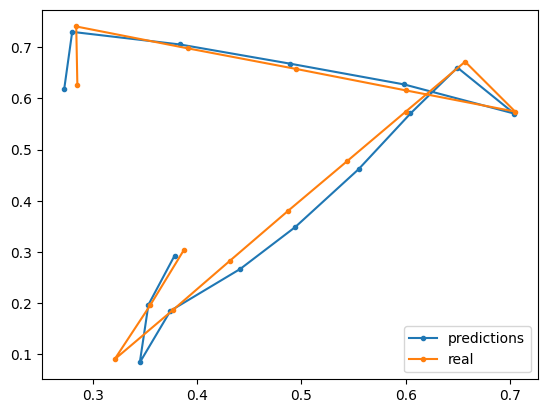

In [28]:
plt.plot(pre_loc[:15,0],pre_loc[:15,1], label = 'predictions', marker = '.')
plt.plot(y_train[:15,0], y_train[:15,1], label = 'real', marker = '.')
# plt.plot(df['vlp_x_hist'], df['vlp_y_hist'])


plt.legend()

# MLP implementation

In [8]:
import robot_vlp.modeling.mlp as mlp

In [11]:
X_test_scaled.shape

(2719, 50, 8)

In [13]:
model = mlp.build_default_mlp()
model.summary()





history = model.fit(
    x = X_train_scaled[:,-1,:], 
    y = expand(y_train),
    validation_data = (X_valid_scaled[:,-1,:],  expand(y_valid)),
    epochs=300, 
    batch_size=32, 
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)] )


pre_loc, pre_ang = model.predict(X_test_scaled[:,-1,:])
MLP_loc_errs = calc_loc_err(pre_loc, y_test[:,:2])

MLP_ang_errs = vec_to_ang(pre_ang) - y_test[:,2]
MLP_ang_errs = np.array([normalize_angle_deg(ang) for ang in MLP_ang_errs])


vlp_ang_errs = y_test[:,2] -  X_test[:,-1,2]
vlp_ang_errs = np.array([normalize_angle_deg(ang) for ang in vlp_ang_errs])


vlp_loc_errs = calc_loc_err(X_test[:,-1,:2], y_test[:,:2])

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step


In [14]:
print(f"vlp pos errs:{vlp_loc_errs.mean()}")
print(f"MLP pos errs:{MLP_loc_errs.mean()}")


print(f"VLP heading errs:{np.abs(vlp_ang_errs).mean()}")
print(f"MLP heading errs:{np.abs(MLP_ang_errs).mean()}")

vlp pos errs:0.03262546356740901
MLP pos errs:0.026327269743040844
VLP heading errs:7.89508272141363
MLP heading errs:4.941748706240032
